# ADS 509 Sentiment Assignment

## Sindhu Bhattarai

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [3]:
# Add any additional import statements you need here


In [4]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# # It's handy to have a full set of emojis

all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)



def common_tokens(tokens):
    return (Counter(tokens).most_common())

    
def is_emoji(s):
    return(emoji.is_emoji(s))

def contains_emoji(s):    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(text, stop_words = sw) :
     # modify this function to remove stopwords
    return(" ".join([word for word in text.split(' ') if word not in stop_words ]))
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    text = text.split(" ")
    # modified this function to return tokens of word only 
    return([words for words in text if words != ''])

def remove_song_title(s): 
    location =  (re.findall(r'"(.*?)"', s)[0])
    return s.replace(location, '')

def get_song_title(s): 
    location =  (re.findall(r'"(.*?)"', str(s))[0])
    return location

def lower_case(text):
    return text.casefold()

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)



In [5]:
# change `data_location` to the location of the folder on your machine.
#data_location = "/users/chandler/dropbox/teaching/repos/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}



In [7]:
artists= os.listdir(lyrics_folder)
artists

['robyn', 'cher']

In [8]:
# Read in the lyrics data
lyrics_title = []
lyrics = []
artist = []

for names in artists: 
    title_path = lyrics_folder+names
    title_ly = os.listdir(title_path)
    #print(title)
    for ly in title_ly:
        current_song_path = lyrics_folder+names+'/'+ly
        lyrics_file = open(current_song_path, "r")
        lyrics_content = (lyrics_file.read()).replace('\n', " ")
        title = ly  
          
        artist.append(str(names))

        lyrics_title.append(title)
        lyrics.append(lyrics_content)
        
lyrics_data = pd.DataFrame({'artist':artist,'title':lyrics_title,'lyrics':lyrics})

lyrics_data.head(5)  
#.head(5)     
        


,artist,title,lyrics
0,robyn,robyn_includemeout.txt,"""Include Me Out"" It is really very simple J..."
1,robyn,robyn_electric.txt,"""Electric"" Electric... It's electric It's ..."
2,robyn,robyn_beach2k20.txt,"""Beach 2K20"" (So you wanna go out? How you ..."
3,robyn,robyn_lovekills.txt,"""Love Kills"" If you're looking for love Get..."
4,robyn,robyn_timemachine.txt,"""Time Machine"" Hey, what did I do? Can't be..."


In [9]:
# Read in the twitter data

twitter_data = pd.read_csv(twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [10]:
twitter_data_2 = pd.read_csv(#data_location + 
    twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [11]:
twitter_data.head(5)

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [12]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

#reading positive sentiment word file and assigning score +1
pos_df = pd.read_csv(positive_words_file,
                           sep="\t",
                           encoding = 'latin-1', skiprows = 33)
pos_df["sentiment"] = "positive"
pos_df = pos_df.rename(columns={pos_df.columns[0]: "word"})

pos_df["score"] = 1

pos_df.head(5)


,word,sentiment,score
0,a+,positive,1
1,abound,positive,1
2,abounds,positive,1
3,abundance,positive,1
4,abundant,positive,1


In [13]:
#reading negative sentiment word file and assigning score -1

neg_df = pd.read_csv(negative_words_file,
                           sep="\t",
                           encoding = 'latin-1', skiprows = 33)
#neg_df.head(35)

neg_df["sentiment"] = "negative"
neg_df = neg_df.rename(columns={neg_df.columns[0]: "word"})
neg_df["score"] = -1
neg_df.head(5)


,word,sentiment,score
0,2-faced,negative,-1
1,2-faces,negative,-1
2,abnormal,negative,-1
3,abolish,negative,-1
4,abominable,negative,-1


In [14]:
#reading tidytext sentiment file and assigning score -1 and +1
tidy_df = pd.read_csv(tidy_text_file,
                           sep="\t",
                           encoding = 'latin-1')#, skiprows = 33)
tidy_df = tidy_df.drop(['lexicon'],axis=1)
tidy_df["score"] = tidy_df["sentiment"].map({'positive':1, 'negative':-1})
tidy_df.head(5)

,word,sentiment,score
0,abandon,negative,-1
1,abandoned,negative,-1
2,abandonment,negative,-1
3,abba,positive,1
4,abduction,negative,-1


In [15]:
#joining all the dataframes after removing duplictaes

sentiment_data = pd.concat([pos_df,neg_df,tidy_df]).drop_duplicates(subset=['word']).reset_index(drop=True)
sentiment_data.head(5)




,word,sentiment,score
0,a+,positive,1
1,abound,positive,1
2,abounds,positive,1
3,abundance,positive,1
4,abundant,positive,1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [16]:
#putting list of positive and negative words  and score 

word_list = sentiment_data["word"].tolist()
word_sentiment_score = sentiment_data["score"].tolist()

#converting two lists into a single dictionary 
word_dict = dict(zip(word_list, word_sentiment_score))
#word_dict


In [17]:
#function for calculating sentiment score. (referenced from book)

def score_sentiment(tokens):
    sentiment_score = 0
    for word in tokens:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(tokens) if len(tokens)>0 else 0

In [19]:
# cleaning the lyrics data 

my_pipeline_lyrics = [remove_song_title,lower_case, remove_punctuation,remove_stop, tokenize]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline_lyrics)
lyrics_data.head(2)


,artist,title,lyrics,tokens
0,robyn,robyn_includemeout.txt,"""Include Me Out"" It is really very simple J...","[really, simple, single, pulse, repeated, regu..."
1,robyn,robyn_electric.txt,"""Electric"" Electric... It's electric It's ...","[electric, natural, high, dont, always, know, ..."


In [20]:
#getting songs title 
pipeline = [get_song_title]
lyrics_data["title"] = lyrics_data["lyrics"].apply(prepare,pipeline=pipeline)
lyrics_data.head(2)

,artist,title,lyrics,tokens
0,robyn,Include Me Out,"""Include Me Out"" It is really very simple J...","[really, simple, single, pulse, repeated, regu..."
1,robyn,Electric,"""Electric"" Electric... It's electric It's ...","[electric, natural, high, dont, always, know, ..."


In [21]:
#applying sentiment score function to lyrics 
lyrics_data['sentiment_scores'] =  lyrics_data['tokens'].apply(score_sentiment)
lyrics_data.head(5)

,artist,title,lyrics,tokens,sentiment_scores
0,robyn,Include Me Out,"""Include Me Out"" It is really very simple J...","[really, simple, single, pulse, repeated, regu...",0.047210
1,robyn,Electric,"""Electric"" Electric... It's electric It's ...","[electric, natural, high, dont, always, know, ...",0.058824
2,robyn,Beach 2K20,"""Beach 2K20"" (So you wanna go out? How you ...","[wanna, go, gonna, get, ok, call, someone, alr...",0.151163
3,robyn,Love Kills,"""Love Kills"" If you're looking for love Get...","[youre, looking, love, get, heart, made, steel...",-0.098361
4,robyn,Time Machine,"""Time Machine"" Hey, what did I do? Can't be...","[hey, cant, believe, fit, threw, stupid, wante...",-0.062992


### Question 1


#### Average sentiment per song of an artist


In [22]:
lyrics_data.groupby('artist')['sentiment_scores'].mean()



artist
cher     0.050884
robyn    0.061790
Name: sentiment_scores, dtype: float64


**Q1: Overall, which artist has the higher average sentiment per song?** 

A: Artist **Robyn** has the highest average sentiment score per song.





### Question 2

#### First artist highest and lowest sentiments


#### Robyn 
#### Highest

In [23]:
robyn = lyrics_data.loc[lyrics_data['artist']=='robyn']
highest = robyn.loc[robyn["sentiment_scores"] == robyn["sentiment_scores"].max()]
highest

,artist,title,lyrics,tokens,sentiment_scores
64,robyn,Baby Forgive Me,"""Baby Forgive Me"" Here come the night In yo...","[come, night, eyes, baby, brave, wise, like, m...",0.52


In [24]:
print("Song with highest sentiment:")

robyn["title"].loc[robyn["sentiment_scores"] == robyn["sentiment_scores"].max()]

Song with highest sentiment:


64    Baby Forgive Me
Name: title, dtype: object

#### Lowest

In [26]:
lowest = robyn.loc[robyn["sentiment_scores"] == robyn["sentiment_scores"].min()]
lowest.head(1)

,artist,title,lyrics,tokens,sentiment_scores
53,robyn,Don't Fucking Tell Me What To Do,"""Don't Fucking Tell Me What To Do"" My drink...","[drinking, killing, drinking, killing, drinkin...",-0.517241


In [27]:
print("Song with Lowest sentiment:")

robyn["title"].loc[robyn["sentiment_scores"] == robyn["sentiment_scores"].min()]

Song with Lowest sentiment:


53    Don't Fucking Tell Me What To Do
75    Don't Fucking Tell Me What To Do
Name: title, dtype: object

**Q2: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.**

A: For artist Robyn song titled **"Baby Forgive Me"** has highest sentiments with **score 0.52** and song titled **"Don't Fucking Tell Me What To Do"** has lowest sentiments with **score -0.517** 



### Question 3

#### Second artist highest and lowest sentiments


#### Cher 
#### Highest

In [28]:
cher = lyrics_data.loc[lyrics_data['artist']=='cher']
highest = cher.loc[cher["sentiment_scores"] == cher["sentiment_scores"].max()]
highest

,artist,title,lyrics,tokens,sentiment_scores
119,cher,My Love,"""My Love"" When I go away I know my heart ca...","[go, away, know, heart, stay, love, understood...",0.52439


In [29]:
print(" Cher song with highest sentiment:")

cher["title"].loc[cher["sentiment_scores"] == cher["sentiment_scores"].max()]

 Cher song with highest sentiment:


119    My Love
Name: title, dtype: object

#### Lowest

In [30]:
lowest = cher.loc[cher["sentiment_scores"] == cher["sentiment_scores"].min()]
lowest

,artist,title,lyrics,tokens,sentiment_scores
145,cher,Bang-Bang,"""Bang-Bang"" Bang bang you shot me down Bang...","[bang, bang, shot, bang, bang, hit, ground, ba...",-0.410405


In [31]:
print("Cher song with Lowest sentiment:")

cher["title"].loc[cher["sentiment_scores"] == cher["sentiment_scores"].min()]

Cher song with Lowest sentiment:


145    Bang-Bang
Name: title, dtype: object


**Q3: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.**

A: For artist Cher song titled **"My Love"** has highest sentiments with **score 0.524** and song titled **"Bang-Bang"** has lowest sentiments with **score -0.41** 





### Question 4

**Q4: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.**



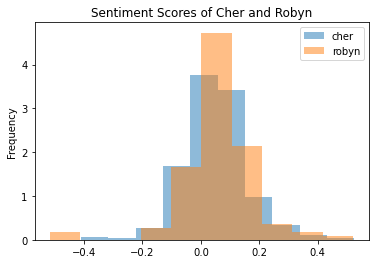

In [32]:
lyrics_data.groupby('artist')['sentiment_scores'].plot(kind="hist",density=True,alpha=0.5,legend=True)
plt.title("Sentiment Scores of Cher and Robyn")
plt.show()

**As we can see in above figure overall robyn's lyrics sentiments seems have higher positive sentiments than cher sentiment with few exceptions on cher's lyrics.**

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

**Approach:**

For twiter description sentiment analysis we need to combine the scoer of both emoji and text. For extracting emoji score I will be making dictionary of 30 positive and 30 negative emojis picked from the most trendy emoji in the link provided which will be later analyzed with text. 

In [33]:
# positive emojis 
pos_emojis = {  '\U0001F495', '\U0001F308', '\U0001F49C','\U0001f600', '\U0001F601',
              '\U0001F60A', '\U0001F607', '\U0001F970',"\u2728", '\U0001F618', 
              '\U0001F60D', '\U0001F60B', '\U0001F61C','\U0001F92A', '\U0001F61D',
              '\U0001F911', '\U0001F917','\U0001F92D','\U0001F60E', '\U0001F49D', 
               '\u2764\ufe0f', '\U0001F48F', '\U0001F913', '\U0001F4AF', '\U0001F619', 
              '\U0001F64C', '\U0001F44F', '\U0001F973', '\U0001F929','\U0001F602'}

In [34]:
#pos_emojis
#len(pos_emojis)


In [35]:
# negative emojis 

neg_emojis= { '\U0001F62A', '\U0001F637', '\U0001F912', '\U0001F915', '\U0001F922', 
             '\U0001F92E', '\U0001F927', '\U0001F975', '\U0001F615', '\U0001F61F',
             '\U0001F641', '\U0001F641', '\U0001F62E', '\U0001F62F', '\U0001F632', 
             '\U0001F97A', '\U0001F622', '\U0001F630', '\U0001F625', '\U0001F62D', 
             '\U0001F616', '\U0001F61E', '\U0001F613', '\U0001F624', '\U0001F621', 
             '\U0001F92C', '\U0001F494', '\U0001F44E', '\U0001F62C', '\U0001F63F', 
             '\U0001F623'}


In [36]:
#neg_emojis
#len(neg_emojis)


In [37]:

#making disctionary of positive and negative emojis with their corresponding score 1 and -1
pos_score = 1
neg_score = -1 

emo_dict = {}

for emoji in pos_emojis:
    emo_dict[emoji] = pos_score
    
for emoji in neg_emojis:
    emo_dict[emoji] = neg_score

#emo_dict

In [38]:
#subsetting relevant columns
twitter_df = twitter_data[['description','artist']]
#twitter_df

In [39]:
#filling null values
twitter_df = twitter_df.fillna('')


In [40]:
#cleaning twitter description
my_pipeline_twitter = [lower_case, remove_punctuation,remove_stop, tokenize]

twitter_df["tokens"] = twitter_df["description"].apply(prepare,pipeline=my_pipeline_twitter)

twitter_df.head(5)


,description,artist,tokens
0,,cher,[]
1,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]"
2,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]"
3,csu,cher,[csu]
4,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"[writer, washinformer, spelmancollege, alumna,..."


In [ ]:
# def score_sentiment(tokens):
#     sentiment_score = 0
#     for word in tokens:
#         if word in word_dict:
#             sentiment_score += word_dict[word]
#     return sentiment_score / len(tokens) if len(tokens)!=0 else 0

In [41]:
#define sentiment_score for text
def sentiment_score(tokens):
    sentiment_score = 0
    for word in tokens:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / (len(tokens)) if len(tokens)!=0 else 0
    

#define sentiment_score for emojis
def emoji_score(tokens):
    emoji_score = 0
    for word in tokens:
        if word in emo_dict:
            emoji_score += emo_dict[word]
    return emoji_score / (len(tokens)) if len(tokens)!=0 else 0
    

In [42]:
#applying sentiment_score and  emoji_score functions to twitter description 
#and calculating combined score

twitter_df['sentiment_scores'] =  twitter_df['tokens'].apply(sentiment_score)
twitter_df['emoji_score'] =  twitter_df['tokens'].apply(emoji_score)

twitter_df['combined_score']= twitter_df['sentiment_scores'] + twitter_df['emoji_score']
twitter_df.head(5)

,description,artist,tokens,sentiment_scores,emoji_score,combined_score
0,,cher,[],0.000000,0.0,0.000000
1,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",0.000000,0.0,0.000000
2,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]",0.000000,0.0,0.000000
3,csu,cher,[csu],0.000000,0.0,0.000000
4,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"[writer, washinformer, spelmancollege, alumna,...",0.176471,0.0,0.176471


In [ ]:
#testing without removing stop words

# from nltk.tokenize import word_tokenize

# def sentiment_score_new(text):
#     sentiment_score = 0
#     bag_of_words = word_tokenize(text.lower())
#     for word in bag_of_words:
#         if word in word_dict:
#             sentiment_score += word_dict[word]
    
#     return sentiment_score / (len(bag_of_words)) if len(bag_of_words)>0 else 0

# def new_emoji_score(text):
#     emoji_score = 0
#     bag_of_words = word_tokenize(text.lower())
#     for word in bag_of_words:
#         if word in emo_dict:
#             emoji_score += emo_dict[word]
#     return emoji_score / len(bag_of_words) if len(bag_of_words)>0 else 0
  

In [ ]:
# twitter_df['description'] = twitter_df['description'].apply(str)


In [ ]:
# twitter_df['sentiment_scores_n'] =  twitter_df['description'].apply(sentiment_score_new)
# twitter_df['emoji_score_n'] =  twitter_df['description'].apply(new_emoji_score)

# twitter_df['combined_score_n']= twitter_df['sentiment_scores_n'] + twitter_df['emoji_score_n']
# twitter_df

### Question 5 

####  Average sentiment of your two artists

In [43]:
#extracting average
twitter_df.groupby('artist')['combined_score'].mean()



artist
cher     0.047773
robyn    0.042850
Name: combined_score, dtype: float64

**Q5: What is the average sentiment of your two artists?**

A: The average sentiments of **Cher** is **0.047** and **Robyn** is **0.0428**

---

#### Question 6

**Most popular positive and negative emoji for each artist**

**Robyn**

In [44]:
#subset for robyn descriptio. data
robyn_df = twitter_df[twitter_df['artist'] == 'robyn']
#robyn_df

In [45]:
robyn_positive_emojis = []
for i in robyn_df['tokens']:
    for token in i:
        if token in pos_emojis:
            robyn_positive_emojis.append(token)

robyn_positive_emojis_count = Counter(robyn_positive_emojis)
print('Most popular positive Emojis for Robyn is:')
print(robyn_positive_emojis_count.most_common(2))

Most popular positive Emojis for Robyn is:
[('❤️', 987), ('✨', 751)]


In [46]:
robyn_negative_emojis = []
for i in robyn_df['tokens']:
    for token in i:
        if token in neg_emojis:
            robyn_negative_emojis.append(token)

robyn_negative_emojis_count = Counter(robyn_negative_emojis)
print('Most popular negative Emojis for Robyn is:')
print(robyn_negative_emojis_count.most_common(2))

Most popular negative Emojis for Robyn is:
[('😷', 25), ('😬', 17)]


**Cher**

In [47]:
#subsent for cher description data
cher_df = twitter_df[twitter_df['artist'] == 'cher']

#cher_df

In [48]:
cher_positive_emojis = []
for i in cher_df['tokens']:
    for token in i:
        if token in pos_emojis:
            cher_positive_emojis.append(token)

cher_positive_emojis_count = Counter(cher_positive_emojis)
print('Most popular positive Emojis for Cher is:')
print(cher_positive_emojis_count.most_common(2))

Most popular positive Emojis for Cher is:
[('❤️', 14715), ('✨', 8343)]


In [49]:
cher_negative_emojis = []
for i in cher_df['tokens']:
    for token in i:
        if token in neg_emojis:
            cher_negative_emojis.append(token)

cher_negative_emojis_count = Counter(cher_negative_emojis)
print('Most popular negative Emojis for Cher is:')
print(cher_negative_emojis_count.most_common(2))

Most popular negative Emojis for Cher is:
[('😷', 734), ('💔', 368)]




**Q: Which positive emoji is the most popular for each artist? Which negative emoji?**

A: For artist Robyn most popular positive emoji is ❤️ with frequency **987** and the most popular negative emoji is 😷  with a frequency of **25**.

Simlarly, for artist Cher most popular  positive emoji is ❤️ with frequency **14715** and negative emoji is 😷 with frequency **734**.  


**Note:** The popular emoji depend on the the emojis which are manually assigned to pos_emojis(30 count) and neg_emojis(30 count). If we assign more positive and negative emojis the results can/might look different. 

